Part b.i) Theta=[2.5134, -0.0010]


<IPython.core.display.Javascript object>


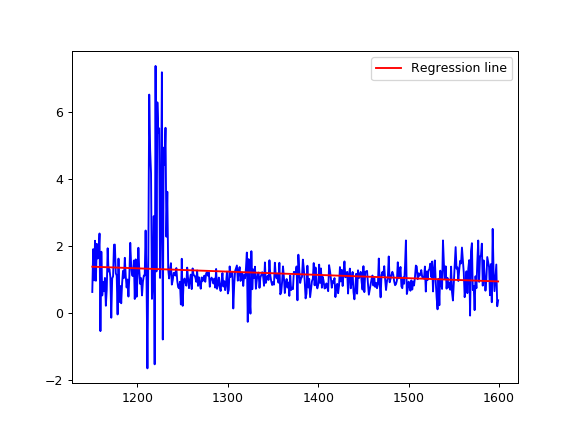

In [1]:
import numpy as np
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from __future__ import division

%matplotlib notebook

def load_data():
    train = np.genfromtxt('quasar_train.csv', skip_header=True, delimiter=',')
    test = np.genfromtxt('quasar_test.csv', skip_header=True, delimiter=',')
    wavelengths = np.genfromtxt('quasar_train.csv', skip_header=False, delimiter=',')[0]
    return train, test, wavelengths

def add_intercept(X_):
    X = None
    # Adding the intercept as Xo = 1. This has to be the size of X_ because it'll be an additional column
    Xo = np.ones(X_.shape)
    X = np.column_stack((Xo,X_))  
    return X

def LR_smooth(Y, X_):
    
    X = add_intercept(X_)
    yhat = np.zeros(Y.shape)
    theta = np.zeros(2)
    
    l1 = (np.linalg.inv(np.dot((X.T),X)))
    l2 = np.dot(X.T, Y)
    theta = np.dot(l1,l2)
    yhat = np.dot(X, theta)
    
    return yhat, theta

def plot_b(X, raw_Y, Ys, desc, filename):
    plt.figure()
    line = plt.plot(X, raw_Y, 'b')
    plt.plot(X, Ys,'r', label = desc)
    plt.legend()
    plt.savefig(filename)

## Part b.i
raw_train, raw_test, wavelengths = load_data()
lr_est, theta = LR_smooth(raw_train[0], wavelengths)
print('Part b.i) Theta=[%.4f, %.4f]' % (theta[0], theta[1]))
plot_b(wavelengths, raw_train[0], lr_est, 'Regression line', 'ps1q5b1.png')


### Theta = [2.5134, -0.0010]

<IPython.core.display.Javascript object>


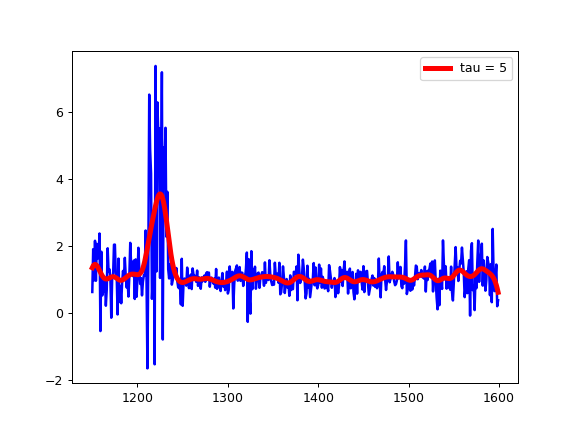

In [2]:
def LWR_smooth(spectrum, wavelengths, tau):
    smooth_spectrum = None
    
    yhat = []
    X = add_intercept(wavelengths)
    Y = spectrum
    
    for i, samp_1 in enumerate(X):
        W = np.zeros((450, 450))
        for j, samp_2 in enumerate(X):
            W[j, j] = np.exp(-1*(samp_1[1]-samp_2[1])*(samp_1[1]-samp_2[1])/(2*tau*tau))
        l0 = np.array(np.dot((X.T),(np.dot(W,X))))
        l1 = np.linalg.inv(l0)
        l2 = np.array(np.dot((X.T),(np.dot(W,Y))))
                
        theta = np.dot(l1,l2)
        yhat.append(np.dot(samp_1, theta))
        
    smooth_spectrum = np.array(yhat)
    
    return smooth_spectrum


def plot_lwr(X, raw_Y, Ys, desc, filename):
    plt.figure()
    plt.plot(X, raw_Y, 'b', linewidth = 2.0)
    plt.plot(X, Ys,'r', linewidth = 4.0, label = desc)
    plt.legend()
    plt.savefig(filename)

## Part b.ii
lwr_est_5 = LWR_smooth(raw_train[0], wavelengths, 5)
plot_lwr(wavelengths, raw_train[0], lwr_est_5,'tau = 5','ps1q5b2.png')


<IPython.core.display.Javascript object>


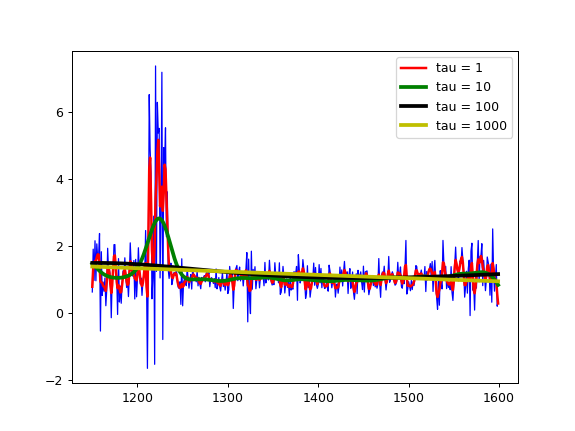

In [3]:
def plot_b3(X, raw_Y, Ys, desc, filename):
    plt.figure()
    plt.plot(X, raw_Y, 'b', linewidth = 1.0)
    plt.plot(X, Ys[0],'r', linewidth = 2.0, label = desc[0])
    plt.plot(X, Ys[1],'g', linewidth = 3.0, label = desc[1])
    plt.plot(X, Ys[2],'k', linewidth = 3.0, label = desc[2])
    plt.plot(X, Ys[3],'y', linewidth = 3.0, label = desc[3])
    plt.legend()
    plt.savefig(filename)

### Part b.iii
lwr_est_1 = LWR_smooth(raw_train[0], wavelengths, 1)
lwr_est_10 = LWR_smooth(raw_train[0], wavelengths, 10)
lwr_est_100 = LWR_smooth(raw_train[0], wavelengths, 100)
lwr_est_1000 = LWR_smooth(raw_train[0], wavelengths, 1000)
plot_b3(wavelengths, raw_train[0],[lwr_est_1, lwr_est_10, lwr_est_100, lwr_est_1000],['tau = 1', 'tau = 10', 'tau = 100', 'tau = 1000'],'ps1q5b3.png')

### Increasing tau (the bandwidth parameter) decreases the effectiveness of the weighted linear smoothing because more variables are considered for smoothing around a sample and the weight of each sample decreases 

In [4]:
def smooth_data(raw, wavelengths, tau):
    smooth = np.array([])
    index = 0
    
    for spectrum in raw:
        smooth_spectrum = LWR_smooth(spectrum, wavelengths, tau)
        
        if(index == 0):
            smooth = smooth_spectrum
            index = index+1
        
        else:      
            smooth = np.vstack((smooth,smooth_spectrum))
            
    return smooth

### Part c.i
smooth_train, smooth_test = [smooth_data(raw, wavelengths, 5) for raw in [raw_train, raw_test]]

In [7]:
def split(full):
    left, right = None, None
    
    left = full[:,0:50]
    right = full[:,150:450]
    
    return left, right

def dist(a, b):
    dist = 0
    dist = np.sum((a-b)**2)
    return dist

def func_reg(left_train, right_train, right_test):
    m, n = left_train.shape
    d_tot = []
    
    for right in right_train:
        d_eval = dist(right, right_test)
        d_tot.append(d_eval)
        
    dist_all = np.hstack(d_tot)
    k_indices = dist_all.argsort()[:3]
    d_max = np.amax(dist_all)
    
    d1 = max((1 - (dist_all[k_indices[0]]/d_max)),0)
    d2 = max((1 - (dist_all[k_indices[1]]/d_max)),0)
    d3 = max((1 - (dist_all[k_indices[2]]/d_max)),0)
    
    f1 = left_train[k_indices[0]]
    f2 = left_train[k_indices[1]]
    f3 = left_train[k_indices[2]]
     
    F = np.vstack((f1,f2))
    F = np.vstack((F,f3))
    
    D = np.array([d1, d2, d3])
    
    lefthat = np.dot(D,F)/(d1+d2+d3)
    lefthat = (lefthat.T)
    return lefthat

#### Part c.ii
left_train, right_train = split(smooth_train)
left_test, right_test = split(smooth_test)

train_errors = [dist(left, func_reg(left_train, right_train, right)) for left, right in zip(left_train, right_train)]
print('Part c.ii) Training error: %.4f' % np.mean(train_errors))

Part c.ii) Training error: 1.0664


### Training error: 1.0664

Part c.iii) Test error: 2.7100


<IPython.core.display.Javascript object>


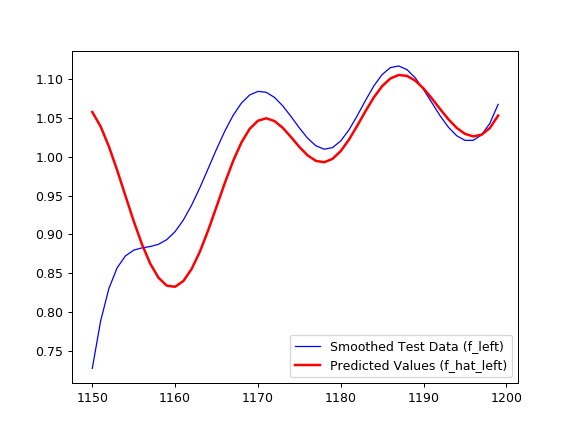

<IPython.core.display.Javascript object>


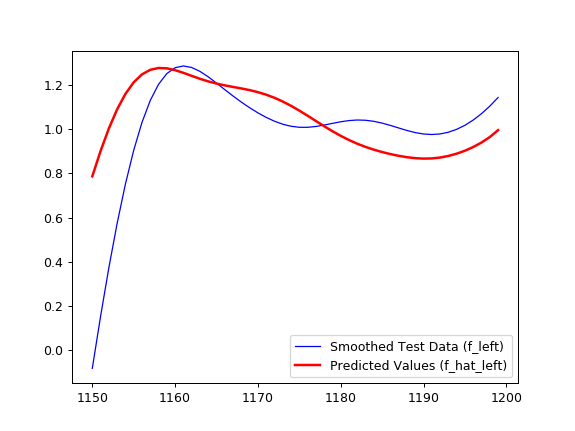

In [8]:
def plot_c(Yhat, Y, X, filename):
    plt.figure()
    plt.plot(X, Y, 'b', linewidth = 1.0, label = 'Smoothed Test Data (f_left)')
    plt.plot(X, Yhat,'r', linewidth = 2.0, label = 'Predicted Values (f_hat_left)')
    plt.legend()
    plt.savefig(filename)
    return

### Part c.iii
test_errors = [dist(left, func_reg(left_train, right_train, right)) for left, right in zip(left_test, right_test)]
print('Part c.iii) Test error: %.4f' % np.mean(test_errors))

left_1 = func_reg(left_train, right_train, right_test[0])
plot_c(left_1, left_test[0], wavelengths[0:50], 'ps1q5c3_1.png')
left_6 = func_reg(left_train, right_train, right_test[5])
plot_c(left_6, left_test[5], wavelengths[0:50], 'ps1q5c3_6.png')

### Test error: 2.7100